In [1]:
import pandas as pd
import numpy as np

import random 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix

torch.manual_seed(666)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW

import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
# pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


1.8.1


In [2]:
df = pd.read_csv('./Data/data_all_lang_balanced_no_test.csv')
df_es_test = pd.read_csv('./Data/es_test_origninal.csv')
df_it_test = pd.read_csv('./Data/it_test_origninal.csv')
df_hi_test = pd.read_csv('./Data/hi_test_origninal.csv')
df_pt_test = pd.read_csv('./Data/pt_test_origninal.csv')
df_fr_test = pd.read_csv('./Data/fr_test_origninal.csv')

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

# reset the indicies

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

In [3]:
df

,text_feat_clean,text_feat_clean_no_emoji,lang_final,target,label,word_count,word_count_no_emoji,trimmed,translated
0,April 3 2020 The global number of coronavirus ...,April 3 2020 The global number of coronavirus ...,en,0,real,98,98,0,0
1,March 20 2020 Pandemics such as the new corona...,March 20 2020 Pandemics such as the new corona...,en,0,real,372,372,0,0
2,What your doctor is reading on Medscape com AP...,What your doctor is reading on Medscape com AP...,en,0,real,396,396,0,0
3,What your doctor is reading on Medscape com AP...,What your doctor is reading on Medscape com AP...,en,0,real,403,396,0,0
4,What your doctor is reading on Medscape com AP...,What your doctor is reading on Medscape com AP...,en,0,real,390,390,0,0
...,...,...,...,...,...,...,...,...,...
7389,50 patients décédés de doute ont déjà été ente...,50 patients who died in doubt have already bee...,fr,1,fake,30,30,0,1
7390,Le virus n'a pas affecté les principales ville...,The virus did not affect the main Chinese citi...,fr,1,fake,16,16,0,1
7391,"Quand les moustiques sortent, tout le monde po...",When the mosquitoes come out everyone WEAR BUG...,fr,1,fake,48,48,0,1
7392,"Un message qui stipule que ""une personne asymp...",A message that states that “An asymptomatic pe...,fr,1,fake,63,63,0,1


In [4]:
df.duplicated().any()

False

In [5]:
def train_val_test_split_df(df, test_size , val_size, random_state, stratify_column):
    # create a intermediary df and the test set
    val_s = val_size/(1-test_size)
    df_int, df_test = train_test_split(df,
                                       stratify=df[stratify_column],
                                       test_size=test_size,
                                       random_state=random_state)
    df_train, df_val = train_test_split(df_int,
                                       stratify=df_int[stratify_column],
                                       test_size=test_size,
                                       random_state=random_state)
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    
    return df_train, df_val, df_test

In [6]:
# initialize tokenizer

MODEL_TYPE = 'xlm-roberta-base'

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)

#from transformers import XLMRobertaForSequenceClassification

model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_TYPE, 
    num_labels = 2, # The number of output labels. 2 for binary classification.
)

# Send the model to the device.
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [7]:
"""The code for the following cell was created using inspiration from : 
https://www.kaggle.com/vbookshelf/basics-of-bert-and-xlm-roberta-pytorch"""

class CompDataset(Dataset):
    
    def __init__(self, df):
        self.df_data = df
        
    def __getitem__(self, index):
        
        text = self.df_data.loc[index, 'text_feat_clean']
        
        
        encoded_dict = tokenizer.encode_plus(text,
                                             add_special_tokens = True,
                                             max_length = 512,
                                             truncation=True,
                                             pad_to_max_length=True,
                                             return_attention_mask=True,
                                             return_tensors ='pt')
        
        # These are torch tensors already.
        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]

        
        # Convert the target to a torch tensor
        target = torch.tensor(self.df_data.loc[index, 'target'])

        sample = (padded_token_list, att_mask, target)

        return sample
    
    def __len__(self):
        return len(self.df_data)


In [8]:
"""The code for the following cell was created using inspiration from : 
https://www.kaggle.com/vbookshelf/basics-of-bert-and-xlm-roberta-pytorch"""

def train(train_dataloader, optimizer, NUM_EPOCHS, model_name):    



    # Set the seed.
    seed_val = 101

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch so we can plot them.
    loss_values = []


    # For each epoch...
    for epoch in range(0, NUM_EPOCHS):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, NUM_EPOCHS))


        stacked_val_labels = []
        targets_list = []

        # ========================================
        #               Training
        # ========================================

        print('Training...')

        # put the model into train mode
        model.train()

        # This turns gradient calculations on and off.
        torch.set_grad_enabled(True)


        # Reset the total loss for this epoch.
        total_train_loss = 0

        for i, batch in enumerate(train_dataloader):

            train_status = 'Batch ' + str(i) + ' of ' + str(len(train_dataloader))

            print(train_status, end='\r')


            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        


            outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        labels=b_labels)

            # Get the loss from the outputs tuple: (loss, logits)
            loss = outputs[0]

            # Convert the loss from a torch tensor to a number.
            # Calculate the total loss.
            total_train_loss = total_train_loss + loss.item()

            # Zero the gradients
            optimizer.zero_grad()

            # Perform a backward pass to calculate the gradients.
            loss.backward()


            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Use the optimizer to update the weights.
            optimizer.step() 



        print('Train loss:' ,total_train_loss/len(train_dataloader))


        # ========================================
        #               Validation
        # ========================================

        print('\nValidation...')

        # Put the model in evaluation mode.
        model.eval()

        # Turn off the gradient calculations.
        # This tells the model not to compute or store gradients.
        # This step saves memory and speeds up validation.
        torch.set_grad_enabled(False)


        # Reset the total loss for this epoch.
        total_val_loss = 0


        for j, batch in enumerate(val_dataloader):

            val_status = 'Batch ' + str(j) + ' of ' + str(len(val_dataloader))

            print(val_status, end='\r')

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)      


            outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

            # Get the loss from the outputs tuple: (loss, logits)
            loss = outputs[0]

            # Convert the loss from a torch tensor to a number.
            # Calculate the total loss.
            total_val_loss = total_val_loss + loss.item()


            # Get the preds
            preds = outputs[1]


            # Move preds to the CPU
            val_preds = preds.detach().cpu().numpy()

            # Move the labels to the cpu
            targets_np = b_labels.to('cpu').numpy()

            # Append the labels to a numpy list
            targets_list.extend(targets_np)

            if j == 0:  # first batch
                stacked_val_preds = val_preds

            else:
                stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


        # Calculate the validation accuracy
        y_true = targets_list
        y_pred = np.argmax(stacked_val_preds, axis=1)

        val_acc = accuracy_score(y_true, y_pred)


        print('Val loss:' ,total_val_loss/len(val_dataloader))
        print('Val acc: ', val_acc)


        # Save the Model
        torch.save(model.state_dict(), model_name+'.pt')

    return model, loss_values


def evaluate(test_dataloader, model):    
    targets_list = []
    for j, batch in enumerate(test_dataloader):

            inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))

            print(inference_status, end='\r')

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, 
                    attention_mask=b_input_mask)


            # Get the preds
            preds = outputs[0]


            # Move preds to the CPU
            preds = preds.detach().cpu().numpy()

            # Move the labels to the cpu
            targets_np = b_labels.to('cpu').numpy()

            # Append the labels to a numpy list
            targets_list.extend(targets_np)

            # Stack the predictions.

            if j == 0:  # first batch
                stacked_preds = preds

            else:
                stacked_preds = np.vstack((stacked_preds, preds))
            
    y_true = targets_list
    y_pred = np.argmax(stacked_preds, axis=1)
    
    return y_true, y_pred
            

def x_language_eval(dataloader, model, fig_name):
    y_true, y_pred = evaluate(dataloader, model)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    figure = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')
    fig = figure.get_figure()
    #fig.savefig(fig_name)
    return y_true, y_pred
    
def ouput_creator(train_lang, model, d_dataloader):
    dict_y_pred = {}
    for i in d_dataloader:
        if i != train_lang:
            print('============='+train_lang +' - '+i+'=============')
            true, preds = x_language_eval(d_dataloader[i], model, train_lang+'_'+i+'_b.png')
            dict_y_pred[train_lang+'_'+i] = [list(true), list(preds)]
        else:
            print('============='+train_lang +' - '+i+'=============')
            true, preds = x_language_eval(test_dataloader, model, i+'_'+i+'_b.png')
            dict_y_pred[train_lang+'_'+i] = [list(true), list(preds)]
            
    return dict_y_pred

In [9]:
L_RATE = 2e-5

NUM_EPOCHS = 3
BATCH_SIZE = 8
NUM_CORES = 6

DF = df_en
df_test = df_es_test

MODEL_NAME = 'model_en_transl_original_test'

# Define the optimizer
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8 
            )


df_train, df_val = train_test_split(DF, test_size=0.2,random_state=565)

df_train=df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
if MODEL_NAME == 'model_english_transl_original_test':
    train_data = CompDataset(df_train)
    val_data = CompDataset(df_val)
    test_data = CompDataset(df_val)
else:
    train_data = CompDataset(df_train)
    val_data = CompDataset(df_val)
    test_data = CompDataset(df_test)


train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        sampler = RandomSampler(train_data),
                                       num_workers=NUM_CORES)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(val_data),
                                       num_workers=NUM_CORES)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=BATCH_SIZE,
                                              sampler=SequentialSampler(test_data), 
                                              num_workers=NUM_CORES)


english_dataloader = torch.utils.data.DataLoader(CompDataset(df_en),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_en),
                                       num_workers=NUM_CORES)

df_es_concat = df_es.append(df_es_test).reset_index(drop=True)
df_it_concat = df_it.append(df_it_test).reset_index(drop=True)
df_hi_concat = df_hi.append(df_hi_test).reset_index(drop=True)
df_pt_concat = df_pt.append(df_pt_test).reset_index(drop=True)
df_fr_concat = df_fr.append(df_fr_test).reset_index(drop=True)

spanish_dataloader = torch.utils.data.DataLoader(CompDataset(df_es_concat),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_es_concat),
                                       num_workers=NUM_CORES)

italian_dataloader = torch.utils.data.DataLoader(CompDataset(df_it_concat),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_it_concat),
                                       num_workers=NUM_CORES)

hindi_dataloader = torch.utils.data.DataLoader(CompDataset(df_hi_concat),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_hi_concat),
                                       num_workers=NUM_CORES)

portuguese_dataloader = torch.utils.data.DataLoader(CompDataset(df_pt_concat),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_pt_concat),
                                       num_workers=NUM_CORES)

french_dataloader = torch.utils.data.DataLoader(CompDataset(df_fr_concat),
                                        batch_size=BATCH_SIZE,
                                        sampler = SequentialSampler(df_fr_concat),
                                       num_workers=NUM_CORES)

d_dataloader = {'en':english_dataloader,
                'es':spanish_dataloader,
                'it':italian_dataloader,
                'hi':hindi_dataloader,
                'pt':portuguese_dataloader, 
                'fr':french_dataloader}

In [10]:
dict_df_lang_mix = {'es':df_es_concat,
                    'it':df_it_concat,
                    'pt':df_pt_concat,
                    'fr':df_fr_concat,
                    'hi':df_hi_concat}

def error_df(test_df, train_lang, dict_preds, dict_test_dfs):
    if train_lang !='en':
        for i in dict_test_dfs:
            if i != train_lang:
                int_df = dict_test_dfs[i]
                int_df['preds'] =  dict_preds[train_lang+'_'+i][1]
                int_df.to_csv('./error_analysis/pred_'+train_lang+'_'+i+'.csv')
            else:
                int_df = test_df
                int_df['preds'] =  dict_preds[train_lang+'_'+i][1]
                int_df.to_csv('./error_analysis/pred_'+train_lang+'_'+i+'.csv')
    else:
        for i in dict_test_dfs:
            if i != train_lang:
                int_df = dict_test_dfs[i]
                int_df['preds'] =  dict_preds[train_lang+'_'+i][1]
                int_df.to_csv('./error_analysis/pred_'+train_lang+'_'+i+'.csv')
        
            
    return 
    
    
    

In [11]:
model, loss_stats = train(train_dataloader, optimizer, NUM_EPOCHS, MODEL_NAME)    


======== Epoch 1 / 3 ========
Training...
Train loss: 0.4153119071962704

Validation...
Val loss: 0.38615434480046756
Val acc:  0.9011857707509882

======== Epoch 2 / 3 ========
Training...
Train loss: 0.23252008144443512

Validation...
Val loss: 0.26428121135472077
Val acc:  0.9433465085638999

======== Epoch 3 / 3 ========
Training...
Train loss: 0.1559134831096009

Validation...
Val loss: 0.27110627705880785
Val acc:  0.9565217391304348


=============en - en=============
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        40
           1       0.81      0.85      0.83        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80

[[32  8]
 [ 6 34]]
=============en - es=============
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       400
           1       0.79      0.94      0.86       400

    accuracy                           0.85       800
   macro avg       0.86      0.85      0.85       800
weighted avg       0.86      0.85      0.85       800

[[301  99]
 [ 22 378]]
=============en - it=============
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       400
           1       0.69      0.98      0.81       400

    accuracy                          

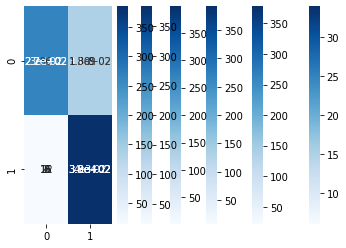

In [12]:
# model trained with translation and downsampling final

dict_en = ouput_creator('en', model,d_dataloader)
error_df(df_val, 'en', dict_en, dict_df_lang_mix)

=============es - en=============
              precision    recall  f1-score   support

           0       0.96      0.44      0.60      1897
           1       0.64      0.98      0.77      1897

    accuracy                           0.71      3794
   macro avg       0.80      0.71      0.69      3794
weighted avg       0.80      0.71      0.69      3794

[[ 836 1061]
 [  35 1862]]
=============es - es=============
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        40
           1       0.92      0.85      0.88        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80

[[37  3]
 [ 6 34]]
=============es - it=============
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       400
           1       0.81      0.98      0.89       400

    accuracy                      

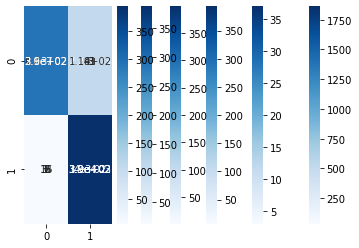

In [23]:
dict_es = ouput_creator('es', model,d_dataloader)
error_df(df_es_test, 'es', dict_es, dict_df_lang_mix)

In [28]:
pred_it = df_it_concat
pred_it['pred'] = dict_es['es_it'][1]
pred_it.to_csv('pred_esit.csv')

pred_pt = df_pt_concat
pred_pt['pred'] = dict_es['es_pt'][1]
pred_pt.to_csv('pred_espt.csv')

pred_hi = df_hi_concat
pred_hi['pred'] = dict_es['es_hi'][1]
pred_hi.to_csv('pred_eshi.csv')

pred_es = df_es_test
pred_es['pred'] = dict_es['es_es'][1]
pred_es.to_csv('pred_eses.csv')

=============fr - en=============
              precision    recall  f1-score   support

           0       0.83      0.48      0.61      1897
           1       0.63      0.90      0.75      1897

    accuracy                           0.69      3794
   macro avg       0.73      0.69      0.68      3794
weighted avg       0.73      0.69      0.68      3794

[[ 908  989]
 [ 183 1714]]
=============fr - es=============
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       400
           1       0.85      0.92      0.88       400

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800

[[337  63]
 [ 33 367]]
=============fr - it=============
              precision    recall  f1-score   support

           0       0.98      0.60      0.74       400
           1       0.71      0.98      0.83       400

    accuracy                  

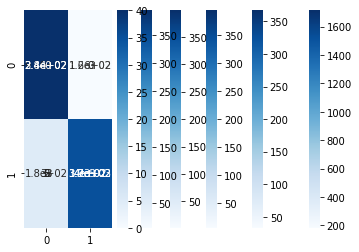

In [12]:
dict_fr = ouput_creator('fr', model,d_dataloader)

In [13]:
error_df(df_fr_test, 'fr', dict_fr, dict_df_lang_mix)

=============hi - en=============
              precision    recall  f1-score   support

           0       0.82      0.59      0.69      1897
           1       0.68      0.87      0.76      1897

    accuracy                           0.73      3794
   macro avg       0.75      0.73      0.73      3794
weighted avg       0.75      0.73      0.73      3794

[[1128  769]
 [ 252 1645]]
=============hi - es=============
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       400
           1       0.68      0.89      0.77       400

    accuracy                           0.73       800
   macro avg       0.76      0.73      0.72       800
weighted avg       0.76      0.73      0.72       800

[[230 170]
 [ 45 355]]
=============hi - it=============
              precision    recall  f1-score   support

           0       0.90      0.32      0.47       400
           1       0.59      0.96      0.73       400

    accuracy                  

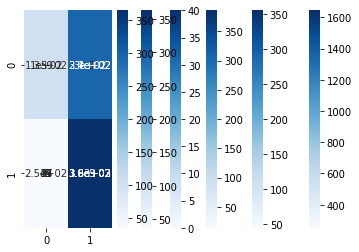

In [12]:
dict_hi = ouput_creator('hi', model,d_dataloader)
error_df(df_hi_test, 'hi', dict_hi, dict_df_lang_mix)

=============it - en=============
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1897
           1       0.80      0.73      0.76      1897

    accuracy                           0.77      3794
   macro avg       0.77      0.77      0.77      3794
weighted avg       0.77      0.77      0.77      3794

[[1548  349]
 [ 521 1376]]
=============it - es=============
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.73      0.84       400

    accuracy                           0.86       800
   macro avg       0.89      0.86      0.86       800
weighted avg       0.89      0.86      0.86       800

[[399   1]
 [108 292]]
=============it - it=============
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        40
           1       1.00      0.30      0.46        40

    accuracy                  

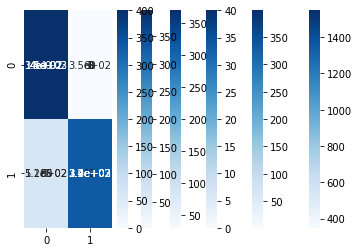

In [13]:
dict_it = ouput_creator('it', model,d_dataloader)
error_df(df_it_test, 'it', dict_it, dict_df_lang_mix)

=============pt - en=============
              precision    recall  f1-score   support

           0       0.90      0.20      0.33      1897
           1       0.55      0.98      0.70      1897

    accuracy                           0.59      3794
   macro avg       0.73      0.59      0.52      3794
weighted avg       0.73      0.59      0.52      3794

[[ 377 1520]
 [  40 1857]]
=============pt - es=============
              precision    recall  f1-score   support

           0       0.93      0.59      0.73       400
           1       0.70      0.96      0.81       400

    accuracy                           0.78       800
   macro avg       0.82      0.78      0.77       800
weighted avg       0.82      0.78      0.77       800

[[238 162]
 [ 17 383]]
=============pt - it=============
              precision    recall  f1-score   support

           0       0.97      0.50      0.66       400
           1       0.66      0.98      0.79       400

    accuracy                  

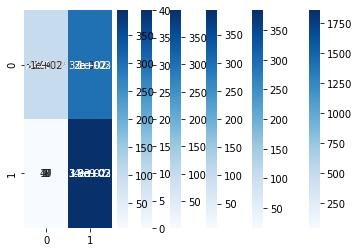

In [12]:
dict_pt = ouput_creator('pt', model,d_dataloader)
error_df(df_pt_test, 'pt', dict_pt, dict_df_lang_mix)